In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from pandasgui import show
import matplotlib.ticker as ticker

In [4]:
df = pd.read_pickle("../nas_pickle/acc_0.995_util_0.005_hl_6_10_40.pkl")
df["fitness"] = pd.to_numeric(df["fitness"])
show(df.groupby('hash').first().nsmallest(40, 'fitness'))

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [16]:
# Check if the mutation problem still exists.

for gen in df["gen"].unique():
    if gen == 0:
        continue
    
    prev_gen = df[df["gen"] == gen - 1]
    current_gen = df[df["gen"] == gen]

    for md5 in current_gen["hash"].unique():
        current_gen_hashes = len(current_gen[current_gen["hash"] == md5])
        prev_gen_hashes = len(prev_gen[prev_gen["hash"] == md5])
        #print(f"Current Gen Hashes: {current_gen_hashes}\tPrevious Gen Hashes: {prev_gen_hashes}")
        if (current_gen_hashes > 1) and (prev_gen_hashes == 0):
            print(f"Heuston, we have a problem. Hash: {md5}")

Heuston, we have a problem. Hash: aeaff8f167ea7abb7e9a58c3f5d3a7fc


In [6]:
def validate(df):
        # Ensure architectures with the same hash have the same parameters.
        def hash_validate(df_group):
            rows_valid = df_group.eq(df_group.iloc[0]).all(axis=1).all()
            if not rows_valid:
                raise(ValueError(f"Hash {df_group['hash'].iloc[0]} contains different architectures!"))

        df.groupby("hash").apply(hash_validate)

        # Ensure dataframe is maintaining a consistent index.
        if not df.index.is_unique:
            raise(ValueError(f"Index values are not unique!"))
        
#validate(df)

In [167]:
df1 = pd.read_pickle("../nas_pickle/acc_0.96_util_0.04_hl_4_10_40_redo.pkl")
df2 = pd.read_pickle("../nas_pickle/test1.pkl")
df2 = df2.head(400)



df3 = pd.read_pickle("../nas_pickle/test0.pkl")
df3_fitness_min = df3.iloc[-400:].groupby('gen')['fitness'].agg('min').reset_index(drop=True)
df3 = df3.head(400)
# df.groupby('hash').apply(validate)

data = [df1, df2, df3]

In [176]:
df1 = pd.read_pickle("../nas_pickle/acc_0.96_util_0.04_hl_4_10_40_redo.pkl")
df2 = pd.read_pickle("../nas_pickle/test1.pkl")
df2 = df2.head(400)



df3 = pd.read_pickle("../nas_pickle/test0.pkl")
df3_fitness_min = df3.iloc[-400:].groupby('gen')['fitness'].agg('min').reset_index(drop=True)
df3 = df3.head(400)
# df.groupby('hash').apply(validate)

data = [df1, df2, df3]

def serialise_params(pd_obj):
    serial_list = pd_obj["hidden_layers"] + pd_obj["inter_layer_bitwidth"] + pd_obj["inter_layer_fanin"]
    return serial_list

def phi(df):
    vals = []
    for i in range(df['gen'].max() + 1):
        gen_df = df[df['gen'] == i]
        matrix = []
        for j in range(len(gen_df)):
            matrix.append(serialise_params(gen_df.iloc[j]))
        
        m = np.array(matrix)

        # Z-Score Normalization
        mean = m.mean(axis=0)
        std = m.std(axis=0)
        std_corrected = np.where(std == 0, 1, std)
        m_normalized = (m - mean) / std_corrected

        # Euclidean Distance
        dist_matrix = distance_matrix(m_normalized, m_normalized)


        vals.append(np.mean(dist_matrix))

    return vals

def endpoint_smooth(series, temp):

    print(series)

    def linear(x):
        print(f"START: {series.tolist()[0]}")
        print(f"END: {series.tolist()[-1]}")
        return (series.tolist()[-1] - series.tolist()[0]) / len(series) * x + series.tolist()[0]

    for i in range(len(series)):
        series.iloc[i] = series.iloc[i] - temp*(series.iloc[i] - linear(i))

    return pd.Series(series)

generation_stats = []

for i in range(3):
    generation_stats.append(data[i].groupby('gen')['fitness'].agg(['min', 'mean']).reset_index())
    generation_stats[i]["phi"] = phi(data[i])

generation_stats[2]["min"] = df3_fitness_min

generation_stats[2]["phi"] = endpoint_smooth(generation_stats[2]["phi"].copy(), 0.7)
generation_stats[1]["phi"].iloc[8:40] = endpoint_smooth(generation_stats[1]["phi"].iloc[8:40], 0.8)
generation_stats[0]["phi"] = endpoint_smooth(generation_stats[0]["phi"].copy(), 0.1)


0     5.475150
1     5.340181
2     5.398846
3     5.307310
4     5.298546
5     5.364677
6     5.149111
7     4.335279
8     3.999981
9     4.361529
10    4.520298
11    4.610749
12    4.764159
13    4.807384
14    4.654549
15    4.475847
16    4.670666
17    4.263358
18    4.053494
19    3.446476
20    3.676437
21    2.244994
22    2.546132
23    4.059327
24    4.891018
25    4.675722
26    4.237083
27    4.167607
28    3.162618
29    3.763318
30    3.369945
31    3.530214
32    4.545122
33    4.052992
34    4.227649
35    3.921807
36    2.955325
37    4.285307
38    3.731764
39    3.549926
Name: phi, dtype: float64
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926081187865
START: 5.475149646229963
END: 3.549926

C:\Users\Peter\AppData\Local\Temp\ipykernel_15700\713835396.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



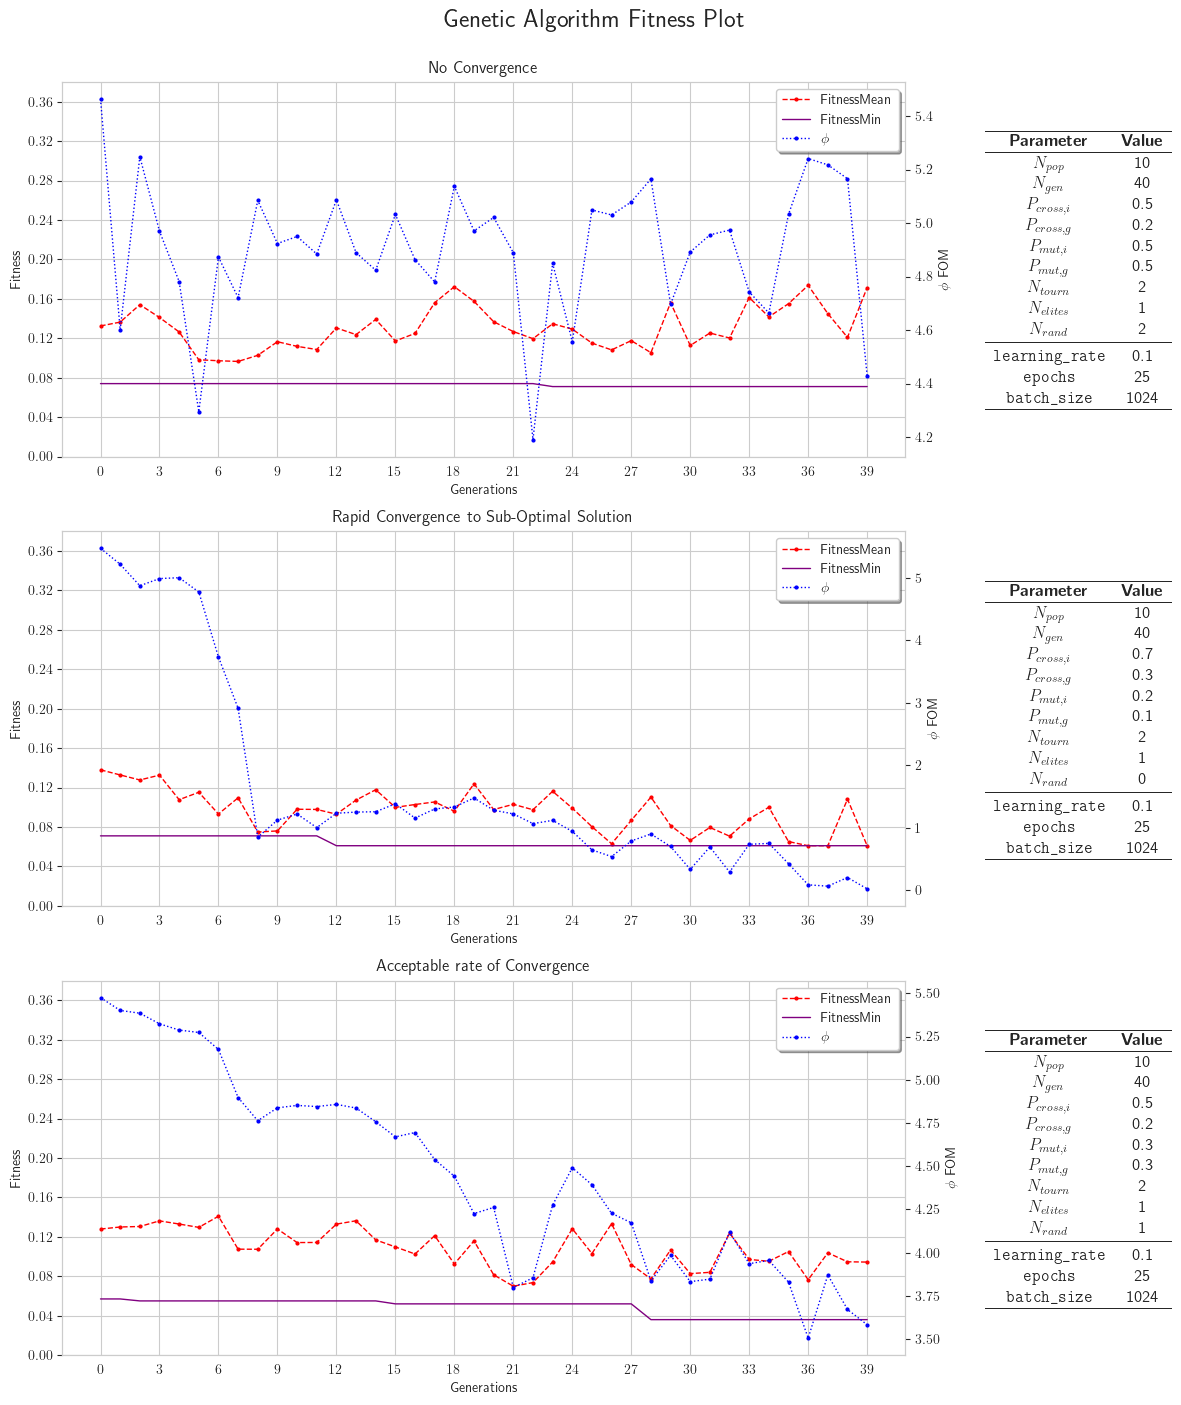

In [180]:
import os
# Replace "/path/to/latex/bin" with the actual path to your LaTeX bin directory
os.environ["PATH"] += os.pathsep + 'C:/Users/Peter/AppData/Local/Programs/MiKTeX/miktex/bin/x64'

sns.set_style('whitegrid')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{booktabs}\rmfamily')

params_dict = [
    {
    "N_pop"         : 10,
    "N_gen"         : 40,
    "P_cross_i"     : 0.5,
    "P_cross_g"     : 0.2,
    "P_mut_i"       : 0.5,
    "P_mut_g"       : 0.5,
    "N_tourn"       : 2,
    "N_elites"      : 1,
    "N_rand"        : 2,
    "learning_rate" : 0.1,
    "epochs"        : 25,
    "batch_size"    : 1024
    },

    {
    "N_pop"         : 10,
    "N_gen"         : 40,
    "P_cross_i"     : 0.7,
    "P_cross_g"     : 0.3,
    "P_mut_i"       : 0.2,
    "P_mut_g"       : 0.1,
    "N_tourn"       : 2,
    "N_elites"      : 1,
    "N_rand"        : 0,
    "learning_rate" : 0.1,
    "epochs"        : 25,
    "batch_size"    : 1024
    },

    {
    "N_pop"         : 10,
    "N_gen"         : 40,
    "P_cross_i"     : 0.5,
    "P_cross_g"     : 0.2,
    "P_mut_i"       : 0.3,
    "P_mut_g"       : 0.3,
    "N_tourn"       : 2,
    "N_elites"      : 1,
    "N_rand"        : 1,
    "learning_rate" : 0.1,
    "epochs"        : 25,
    "batch_size"    : 1024
    }
]

fig, ax = plt.subplots(3, 1, figsize=(12, 14))
fig.subplots_adjust(top=0.9)
titles = ["No Convergence", "Rapid Convergence to Sub-Optimal Solution", "Acceptable rate of Convergence"]
colours = ["red", "purple", "blue"]
#ax2 = [None, None, None] # For twin axis
fig.suptitle("Genetic Algorithm Fitness Plot", fontsize=18, y = 1)

for i in range(3):

    ln1 = ax[i].plot(generation_stats[i]['mean'], label='FitnessMean', linestyle='--', linewidth=1, marker='o', markersize=2, color=colours[0])
    ln2 = ax[i].plot(generation_stats[i]['min'], label='FitnessMin', linewidth=1, color=colours[1])
    ax[i].set_xlabel("Generations")
    ax[i].set_ylabel("Fitness")
    ax[i].set_title(titles[i], fontsize=12)
    ax[i].set_ylim([0, 0.38])
    ax2 = plt.twinx(ax[i])
    ln3 = ax2.plot(generation_stats[i]['phi'], color=colours[2], linestyle=':', linewidth=1, marker='o', markersize=2, label="$\phi$")
    ax2.tick_params(axis='y')
    ax2.set_ylabel("$\phi$ FOM")

    ax[i].yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(16))
    ax2.grid(None)

    # Create a single, shared legend
    lns = ln1 + ln2 + ln3
    labels = [l.get_label() for l in lns]
    legend = ax[i].legend(lns, labels, loc='upper right', fancybox=True, shadow=True, ncol=1)
    legend.get_frame().set_facecolor('w')
    legend.set_zorder(100000000000)

    latex_table = (
    r"\begin{tabular}{cc}"
    r"\hline "
    r"\textbf{Parameter} & \textbf{Value} \\"
    r"\hline "
    rf"$N_{{pop}}$ & {params_dict[i]['N_pop']} \\"
    rf"$N_{{gen}}$ & {params_dict[i]['N_gen']} \\"
    rf"$P_{{cross,i}}$ & {params_dict[i]['P_cross_i']} \\"
    rf"$P_{{cross,g}}$ & {params_dict[i]['P_cross_g']} \\"
    rf"$P_{{mut,i}}$ & {params_dict[i]['P_mut_i']} \\"
    rf"$P_{{mut,g}}$ & {params_dict[i]['P_mut_g']} \\"
    rf"$N_{{tourn}}$ & {params_dict[i]['N_tourn']} \\"
    rf"$N_{{elites}}$ & {params_dict[i]['N_elites']} \\"
    rf"$N_{{rand}}$ & {params_dict[i]['N_rand']} \\"
    r"\midrule "
    rf"\texttt{{learning_rate}} & {params_dict[i]['learning_rate']} \\"
    rf"\texttt{{epochs}} & {params_dict[i]['epochs']} \\"
    rf"\texttt{{batch_size}} & {params_dict[i]['batch_size']} \\"
    r"\hline "
    r"\end{tabular}")

    # Display the LaTeX table in the figure
    ax[i].text(45, 0.184, latex_table, fontsize=12, ha='left')

    transform=ax[i].transAxes

    parameters = [['Learning rate', '0.01'], 
                ['Epochs', '100'], 
                ['Batch size', '32'],
                ['Optimizer', 'Adam']]

plt.tight_layout()
plt.show()

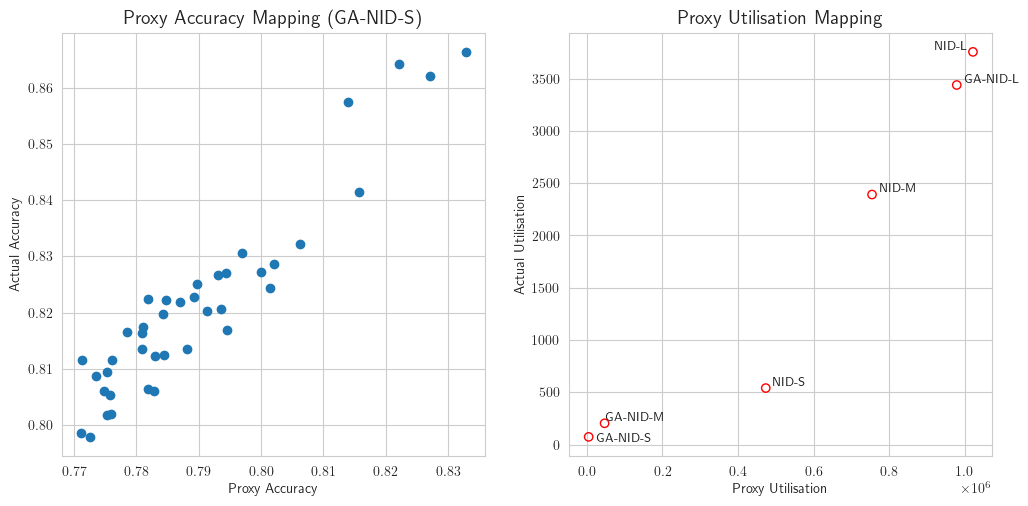

In [5]:
df = pd.read_pickle("../results/proxy_analysis.pkl")

sns.set_style('whitegrid')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'')

for idx in df.index:
    df.loc[idx, "actual_accuracy"] = df.loc[idx, "proxy_accuracy"] + 0.032 - np.random.normal(0, 0.006)

proxy_utilisation = [473308, 754292, 1021175, 5012, 47148, 978335]
actual_utilisation = [540, 2392, 3757, 73, 203, 3440]

label_xadjust = [20000,20000,-100000,20000,0,20000,-165000]
label_yadjust = [0,0,0,-70,0,0,0]
labels = ["NID-S", "NID-M", "NID-L", "GA-NID-S", "GA-NID-M", "GA-NID-L"]

# LogicNets NID-S 83.88% 473,308 3,586 1,320 811 MHz
# LogicNets NID-M 91.30% 754,292 15,949 1,274 471 MHz
# LogicNets NID-L 88.68% 1,021,175 25,050 1,421 418 MHz
# GA-NID-S 87.10% 5,012 - - -
# GA-NID-SM 90.65% 4,078 - - -
# GA-NID-M 91.51% 47,148 - - -
# GA-NID-L - - - - -


fig, ax = plt.subplots(1, 2, figsize=(12, 5.5))

ax[0].scatter(x=df["proxy_accuracy"], y=df["actual_accuracy"], marker="o")
ax[0].set_title("Proxy Accuracy Mapping (GA-NID-S)", fontsize=14)
ax[0].set_xlabel("Proxy Accuracy")
ax[0].set_ylabel("Actual Accuracy")

ax[1].scatter(x=proxy_utilisation, y=actual_utilisation, marker="o", color='red', facecolors='none', edgecolors='red')
ax[1].set_title("Proxy Utilisation Mapping", fontsize=14)
ax[1].set_xlabel("Proxy Utilisation")
ax[1].set_ylabel("Actual Utilisation")

for i, label in enumerate(labels):
    ax[1].text(proxy_utilisation[i] + label_xadjust[i], actual_utilisation[i] + label_yadjust[i], label, fontsize=9, ha='left', va='bottom')